# The evolution of trust and trustworthiness
## By Alex MARCELINO SANTEE, Jean-Nicolas GREGOIRE, Sacha TESTAERT

In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

import time
from datetime import datetime
from zoneinfo import ZoneInfo

from abc import ABC, abstractmethod
from collections import Counter
import random

from multiprocessing import Pool

### Parameters

##### Single game (Trust game, binary decision)
##### Strategies are a combination of A,B (T,R), (T,B), (N,R), (N,B)

##### Game matrix:
|     |  R                 |  B                |
|-----|------------------------|-------------------|
|  T  |  1 + (3r - 1)x, 3(1 - r)x  |  1 - x, 3x  |
|  N  |  1, 0              |  1, 0        |


### Trust Game Auxiliary Functions

In [2]:
def act2int(action: str):
    if action == "T" or action == "R":
        return 0
    else:
        return 1


def gen_trust_matrix(x=1, r=0.5):
    # Trust Game Matrix
    #   R B
    # T
    # N
    matrix = np.array([
        [[1-x+3*r*x, 3*x*(1-r)], [1-x, 3*x]],
        [[1, 0], [1, 0]],
    ])
    return matrix

# Multiple network types - pair are generated from connected nodes
# heterogeneous networks can consider different degree (normalized) or not
# unnormalized scale-free network is the only to evolve trust

### Abstract network class

In [3]:
class AgentNetwork(ABC):

    def get_strategy(self, agent):
        return self.strategies[agent]

    def set_strategy(self, agent, strategy):
        self.strategies[agent] = strategy
        return
        # if strategy in strategy_labels:
        #     self.strategies[agent] = strategy
        #     return
        # else:
        #     raise ValueError("Setting invalid strategy: " + str(strategy))

    def get_ratios(self):
        count = Counter(self.strategies)
        ratios = np.empty(nb_strategies)
        for i, strategy in enumerate(strategy_labels):
            ratios[i] = count[strategy]
        return ratios/self.size

    def get_size(self):
        return self.size

    @abstractmethod
    def get_neighbors(self, agent):
        pass

    def get_num_neighbor(self, agent):
        if self.neighbor_count[agent] is None:
            self.neighbor_count[agent] = len(self.get_neighbors(agent))
        return self.neighbor_count[agent]
    
    def sample_neighbors(self, agent, n=4, replacement=True):
        if replacement:
            if self.sample_cache[agent][0] >= self.cs:
                neighbors = self.get_neighbors(agent)
                self.sample_cache[agent][1] = np.random.choice(neighbors,
                                                               (self.cs, n))
                self.sample_cache[agent][0] = 0
            agents = self.sample_cache[agent][1][self.sample_cache[agent][0]]
            self.sample_cache[agent][0] += 1
        else:
            neighbors = self.get_neighbors(agent)
            agents = random.sample(neighbors, n)
        return agents
    
    def __str__(self):
        return str(self.strategies)

### Well mixed network

In [4]:
class WellMixed(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.strategies = random.choices(strategy_labels, k=size)
        self.neighbor_count = size*[None]
        self.cs = 1024  # cache size
        self.sample_cache = []  # improves sampling performance
        for _ in range(self.size):
            self.sample_cache.append([self.cs, np.empty((self.cs, 4))])

    def get_neighbors(self, agent):
        neighbors = [x for x in range(self.size) if x != agent]
        return neighbors

### Square lattice network

In [5]:
class SquareLattice(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.rows = math.ceil(self.size**(1/2))
        self.cols = math.ceil(self.size**(1/2))
        self.network = self._create_square_lattice(self.rows, self.cols)
        self.strategies = random.choices(strategy_labels, k=self.size)
        self.neighbor_count = size*[None]

        self.cs = 1024  # cache size
        self.sample_cache = []  # improves sampling performance
        for _ in range(self.size):
            self.sample_cache.append([self.cs, np.empty((self.cs, 4))])

    def _create_square_lattice(self, rows, cols):
        G = nx.grid_2d_graph(rows, cols, periodic=True) #must remain to True, otherwise the network is padded
        mapping = {node: idx for idx, node in enumerate(G.nodes)}
        # Relabel nodes in the graph using the mapping 
        # (G is first created with tuples representing nodes id and coordinates 
        # but since we want to sample over them, it's easier with one dimensional identificator)
        G = nx.relabel_nodes(G, mapping)
        return G    

    def get_neighbors(self, agent):
        return list(self.network.neighbors(agent))

### Triangle lattice network

In [6]:
class TriangleLattice(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.rows = math.ceil(self.size**(1/2)*2)
        self.cols = math.ceil(self.size**(1/2))
        self.network = self._create_triangular_lattice(self.rows, self.cols)
        self.strategies = random.choices(strategy_labels, k=self.size)
        self.neighbor_count = size*[None]

        self.cs = 1024  # cache size
        self.sample_cache = []  # improves sampling performance
        for _ in range(self.size):
            self.sample_cache.append([self.cs, np.empty((self.cs, 4))])

    def _create_triangular_lattice(self, rows, cols):
        G = nx.triangular_lattice_graph(rows, cols, periodic=True) 
        mapping = {node: idx for idx, node in enumerate(G.nodes)}
        G = nx.relabel_nodes(G, mapping)
        return G

    def get_neighbors(self, agent):
        return list(self.network.neighbors(agent))

### Hexagonal lattice network

In [7]:
class HexagonLattice(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.rows = math.ceil(self.size**(1/2)/2)
        self.cols = math.ceil(self.size**(1/2))
        self.network = self._create_hexagonal_lattice(self.rows, self.cols)
        self.strategies = random.choices(strategy_labels, k=self.size)
        self.neighbor_count = size*[None]

        self.cs = 1024  # cache size
        self.sample_cache = []  # improves sampling performance
        for _ in range(self.size):
            self.sample_cache.append([self.cs, np.empty((self.cs, 4))])

    def _create_hexagonal_lattice(self, rows, cols):
        G = nx.hexagonal_lattice_graph(rows, cols, periodic=True)
        mapping = {node: idx for idx, node in enumerate(G.nodes)}
        G = nx.relabel_nodes(G, mapping)
        return G

    def get_neighbors(self, agent):
        return list(self.network.neighbors(agent)) 

### Scale Free network using Barabási–Albert algorithm

In [8]:
class ScaleFree(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.network = self._create_scale_free_network()
        self.strategies = random.choices(strategy_labels, k=self.size)
        self.neighbor_count = size*[None]

        self.cs = 1024  # cache size
        self.sample_cache = []  # improves sampling performance
        for _ in range(self.size):
            self.sample_cache.append([self.cs, np.empty((self.cs, 4))])

    def _create_scale_free_network(self):
        # second argument here is the number of edges to consider when adding a new node to the graph
        G = nx.barabasi_albert_graph(self.size, 2) 
        mapping = {node: idx for idx, node in enumerate(G.nodes)}
        G = nx.relabel_nodes(G, mapping)
        return G

    def get_neighbors(self, agent):
        return list(self.network.neighbors(agent))

### Random Network using Erdös–Rényi

In [9]:
class Random(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.network = self._create_random_network()
        self.strategies = random.choices(strategy_labels, k=self.size)
        self.neighbor_count = size*[None]

        self.cs = 1024  # cache size
        self.sample_cache = []  # improves sampling performance
        for _ in range(self.size):
            self.sample_cache.append([self.cs, np.empty((self.cs, 4))])

    def _create_random_network(self):
        G = nx.erdos_renyi_graph(self.size, 0.3)
        mapping = {node: idx for idx, node in enumerate(G.nodes)}
        G = nx.relabel_nodes(G, mapping)
        return G

    def get_neighbors(self, agent):
        return list(self.network.neighbors(agent))

### Simulation

###### Copy of other players actions with probability from eq. 2.1
$$ w = \frac{1}{ 1 + \frac{e^{\text{payoff}_{p_2}-\text{payoff}_{p_1}}}{K} } $$ for K=0.1
###### number of MC steps equals to population size N=484 (close to 500 from paper in order to have a perfect square that is 22*22)
###### Initializes each player randomly consists in chosing two players P1, P2 and playing the game w/ 4 neighbors

In [10]:
def simulation_step(
        network: AgentNetwork,
        payoff_matrix: np.ndarray,
        K: float = 0.1
        ):
    N_PLAYERS = 2
    N_GAMES = 4

    # sample 2 players according to the lattices requirements if it is a Lattice instance 
    # else according to the WellMixed population criteria
    if not isinstance(network, WellMixed) and not isinstance(network, ScaleFree) and not isinstance(network, Random):
        players = random.sample(range(network.get_size()), 1) # first player selected randomly
        players.extend(network.sample_neighbors(players[0],1,replacement=False)) # second among neighbors

    else:
        players = random.sample(range(network.get_size()), N_PLAYERS) # both players selected randomly

    payoffs = N_PLAYERS*[0]
    for play_idx, player in enumerate(players):
        # plays 4 games for each player
        adversaries = network.sample_neighbors(player, n=N_GAMES)
        for adversary in adversaries:

            # decide roles
            role = random.randint(0, 1)  # 0 player sends, 1 player receive
            # gets actions
            if role == 0:
                act0 = network.get_strategy(player)[1]
                act1 = network.get_strategy(adversary)[3]
            else:
                act0 = network.get_strategy(adversary)[1]
                act1 = network.get_strategy(player)[3]
            # calculates payoff for the game
            payoff = payoff_matrix[act2int(act0), act2int(act1), role]

            payoffs[play_idx] += payoff
        payoffs[play_idx] /= network.get_num_neighbor(player)  # normalization

    # p2 copies p1 with chance w
    w = 1 / (1 + np.exp(payoffs[1]-payoffs[0])/K)
    if random.random() < w:
        network.set_strategy(players[1],
                             network.get_strategy(players[0]))

    return network


def simulation_single_run(payoff_matrix: np.ndarray, population_type: str="ScaleFree", pop_size=484, K=0.1):
    results = np.empty((nb_time_steps, nb_strategies))

    if population_type == "SquareLattice":
        network = SquareLattice(pop_size)
        #print(network.network.number_of_nodes())
    elif population_type == "TriangleLattice":
        network = TriangleLattice(pop_size)
        #print(network.network.number_of_nodes())
    elif population_type == "HexagonLattice":
        network = HexagonLattice(pop_size)
        #print(network.network.number_of_nodes())
    elif population_type == "ScaleFree":
        network = ScaleFree(pop_size)
        #print(network.network.number_of_nodes())
    elif population_type == "Random":
        network = Random(pop_size)
        #print(network.network.number_of_nodes())
    elif population_type == "WellMixed":
        network = WellMixed(pop_size)
    elif population_type == "WellMixedGoodSamaritan":
        network = WellMixedGoodSamaritan(pop_size)

    for timestep in range(nb_time_steps):
        for _ in range(pop_size):  # Each MC step is the size of population
            network = simulation_step(network, payoff_matrix, K)
        results[timestep] = network.get_ratios()
    return results

def single_run_aux(input_tuple):
    payoff_matrix, population_type, pop_size, K = input_tuple
    return simulation_single_run(payoff_matrix, population_type, pop_size, K)

def run_simulation(payoff_matrix: np.ndarray, population_type: str="ScaleFree", pop_size=484, K=0.1):
    results = np.empty((nb_runs, nb_time_steps, nb_strategies))
    with Pool(processes=n_threads) as p:
        it = p.imap_unordered(single_run_aux, nb_runs*[(payoff_matrix, population_type, pop_size, K)])
        for run, result in enumerate(it):
            results[run] = result
    return results

### Plotting

#### 1- Proportion of population sweeping through x and r
#### 2- Evolution Through time given x and r

---

###### Research question - what if keep memory of neighbor, can we train for (x,r)? What are ultimatum game and dictator game?
###### To trust or not to trust proposes a better N-player generalization with code and found incentives to trustees and non-linear reward create rich evolution hierarchical trust fixes proportion of trusters and trustees and introduces punishing truster, getting stability of trustworthy and punishers.

###### N-player trust game proposes variation with governors and citizens which players can select what to be (doesn't look interesting) converge to no trust unless population is full of trustworthy. To trust or not to trust cites it directly, but with strong criticism

In [11]:
def plot_heatmaps(avg_results, network_type):
    fig, axs = plt.subplots(figsize=(10, 5), ncols=2, nrows=2)
    fig.suptitle(f"x,r sweep for {network_type}")
    
    im = axs[0, 0].imshow(avg_results[:, :, 0], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)
    axs[0, 1].imshow(avg_results[:, :, 1], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)
    axs[1, 0].imshow(avg_results[:, :, 2], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)
    axs[1, 1].imshow(avg_results[:, :, 3], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)

    axs[0, 0].text(0.8, 0.8, "(T,R)", backgroundcolor="white")
    axs[0, 1].text(0.8, 0.8, "(T,B)", backgroundcolor="white")
    axs[1, 0].text(0.8, 0.8, "(N,R)", backgroundcolor="white")
    axs[1, 1].text(0.8, 0.8, "(N,B)", backgroundcolor="white")

    axs[0, 0].set_xticks([])
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    axs[1, 1].set_yticks([])

    axs[0, 0].set_ylabel("$r$", fontsize=14)
    axs[1, 0].set_ylabel("$r$", fontsize=14)
    axs[1, 0].set_xlabel("$x$", fontsize=14)
    axs[1, 1].set_xlabel("$x$", fontsize=14)

    fig.colorbar(im, ax=axs[:, :])
    plt.show()

In [12]:
%%capture output1

colors = ["black", "green", "red", "blue"]
strategy_labels = ["(T,R)", "(T,B)", "(N,R)", "(N,B)"]
network_types = ["WellMixed", "ScaleFree", "SquareLattice", "Random", "TriangleLattice", "HexagonLattice"]
xrs = [(1,0.5), (0.1,0.3), (0.1,0.8)]
K = 0.1

nb_strategies = 4
nb_runs = 1 # 16
nb_time_steps = 2 #100
n_threads = 8

now = datetime.now(tz=ZoneInfo("Europe/Brussels"))
print("Starting simulations at ", now)

for net_type in network_types:
    
    old_ts = nb_time_steps
    nb_time_steps = 2 # 10000 ----------------------------------------------------------------------
    for x,r in xrs:
        game_matrix = gen_trust_matrix(x, r)
    
        t = np.arange(0, nb_time_steps)
        start = time.time()
        results = run_simulation(game_matrix, net_type)
        results = np.asarray(results)
        end =time.time()
        print(f"Evolution simulation took {end-start:.2f} s for nb_runs={nb_runs}, nb_steps={nb_time_steps} and n_threads={n_threads}, x={x:.2f} r={r:.2f}")
        
        # Plot for population evolution
        
        fig, ax = plt.subplots(figsize=(10, 3))
        
        for run in results:
            for i in range(nb_strategies):
                ax.plot(t, run[:, i],
                        linewidth=.05, alpha=0.6, color=colors[i])
        
        for i in range(nb_strategies):
            ax.plot(t, np.mean(results[:, :, i], axis=0), linewidth=1.5,
                    alpha=1, color=colors[i], label=strategy_labels[i])
        
        ax.set_title(f"evolution for $x$={x} and $r$={r}, {net_type}")
        ax.legend(frameon=False, bbox_to_anchor=(1.1, 1, 0, 0), loc='upper right')
        ax.set_ylabel("density", fontsize=14)
        ax.set_yscale("log")
        ax.set_xlabel("MC steps, $(t)$", fontsize=14)
        ax.set_xscale("log")
        sns.despine()
        plt.show()
    nb_time_steps = old_ts
    
    # Sweep plot
    
    xs = np.linspace(0, 1, 20)
    rs = np.linspace(0, 1, 20)
    t = np.arange(0, nb_time_steps)
    final_proportions = np.empty((xs.shape[0], rs.shape[0], nb_strategies))
    start = time.time()
    for i, x in enumerate(xs):
        for j, r in enumerate(rs):
            payoff = gen_trust_matrix(x, r)
            result = np.array(run_simulation(payoff, net_type))
            # not sure about order i,j looks transposed
            final_proportions[j, i] = np.sum(result[:, -1, :], axis=0)/nb_runs
    end =time.time()
    print(f"400 evolutions simulation took {end-start:.2f} s for nb_runs={nb_runs}, nb_steps={nb_time_steps} and n_threads={n_threads}")
    plot_heatmaps(final_proportions, net_type)

### Good Samaritan

In [13]:
%%capture output2

class WellMixedGoodSamaritan(WellMixed):
    def __init__(self, size):
        super().__init__(size)
        self.strategies[0] = "(T,R)"

    # impossible to replace good samaritan's strategy
    def set_strategy(self, agent, strategy):
        if agent == 0:
            return
        self.strategies[agent] = strategy
        return

    # ratios exclude good samaritan
    def get_ratios(self):
        count = Counter(self.strategies)
        ratios = np.empty(nb_strategies)
        for i, strategy in enumerate(strategy_labels):
            ratios[i] = count[strategy]
        ratios[0] -= 1
        return ratios/(self.size-1)

old_ts = nb_time_steps
nb_time_steps = 10000
x,r = 1.0, 0.5
game_matrix = gen_trust_matrix(x, r)

t = np.arange(0, nb_time_steps)
start = time.time()
results = run_simulation(game_matrix, "WellMixedGoodSamaritan")
results = np.asarray(results)
end =time.time()
print(f"Evolution simulation took {end-start:.2f} s for nb_runs={nb_runs}, nb_steps={nb_time_steps} and n_threads={n_threads}, x={x:.2f} r={r:.2f}")

# Plot for population evolution

fig, ax = plt.subplots(figsize=(10, 3))

for run in results:
    for i in range(nb_strategies):
        ax.plot(t, run[:, i],
                linewidth=.05, alpha=0.6, color=colors[i])

for i in range(nb_strategies):
    ax.plot(t, np.mean(results[:, :, i], axis=0), linewidth=1.5,
            alpha=1, color=colors[i], label=strategy_labels[i])

ax.set_title(f"evolution for $x$={x} and $r$={r}, WellMixed with Good Samaritan")
ax.legend(frameon=False, bbox_to_anchor=(1.1, 1, 0, 0), loc='upper right')
ax.set_ylabel("density", fontsize=14)
ax.set_yscale("log")
ax.set_xlabel("MC steps, $(t)$", fontsize=14)
ax.set_xscale("log")
sns.despine()
plt.show()
nb_time_steps = old_ts

KeyboardInterrupt: 

### Noise (K) sweep

Now that we studied the evolution of densities around their network structure, we try and analyze the evolution of strategies according to the variation of the noise in the replicator dynamycs.

trying the values K = 1, K = 10, K = 100

In [14]:
%%capture output3

old_ts = nb_time_steps
nb_time_steps = 10000
for K in [1, 10, 100]:
    x, r = 1, 0.5
    game_matrix = gen_trust_matrix(x, r)

    t = np.arange(0, nb_time_steps)
    start = time.time()
    results = run_simulation(game_matrix, "WellMixed", K=K)
    results = np.asarray(results)
    end =time.time()
    print(f"Evolution simulation took {end-start:.2f} s for nb_runs={nb_runs}, nb_steps={nb_time_steps} and n_threads={n_threads}, x={x:.2f} r={r:.2f}")
    
    # Plot for population evolution
    
    fig, ax = plt.subplots(figsize=(10, 3))
    
    for run in results:
        for i in range(nb_strategies):
            ax.plot(t, run[:, i],
                    linewidth=.05, alpha=0.6, color=colors[i])
    
    for i in range(nb_strategies):
        ax.plot(t, np.mean(results[:, :, i], axis=0), linewidth=1.5,
                alpha=1, color=colors[i], label=strategy_labels[i])
    
    ax.set_title(f"evolution for $x$={x} and $r$={r}, WellMixed, K={K}")
    ax.legend(frameon=False, bbox_to_anchor=(1.1, 1, 0, 0), loc='upper right')
    ax.set_ylabel("density", fontsize=14)
    ax.set_yscale("log")
    ax.set_xlabel("MC steps, $(t)$", fontsize=14)
    ax.set_xscale("log")
    sns.despine()
    plt.show()
nb_time_steps = old_ts

KeyboardInterrupt: 

Starting simulations at  2025-01-09 10:25:17.581015+01:00
Evolution simulation took 314.90 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=1.00 r=0.50
Evolution simulation took 323.81 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=0.10 r=0.30
Evolution simulation took 323.13 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=0.10 r=0.80
400 evolutions simulation took 1367.42 s for nb_runs=16, nb_steps=100 and n_threads=8
Evolution simulation took 327.72 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=1.00 r=0.50
Evolution simulation took 326.26 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=0.10 r=0.30
Evolution simulation took 325.64 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=0.10 r=0.80
400 evolutions simulation took 1347.86 s for nb_runs=16, nb_steps=100 and n_threads=8
Evolution simulation took 373.58 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=1.00 r=0.50
Evolution simulation took 387.82 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=0.10 r

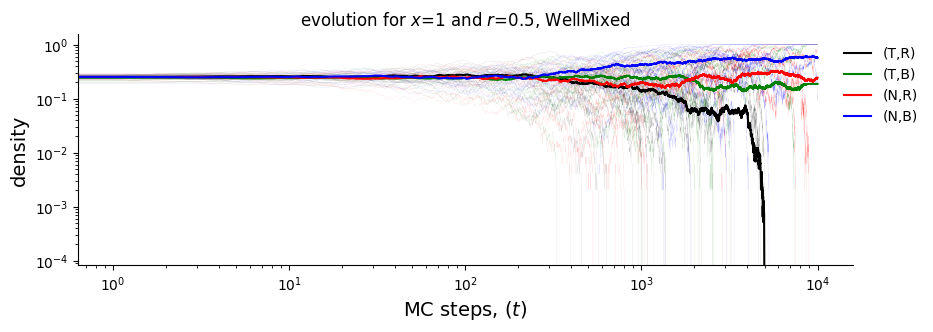

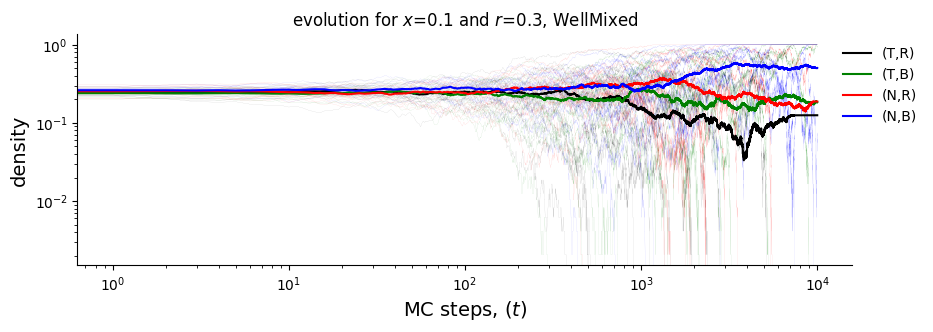

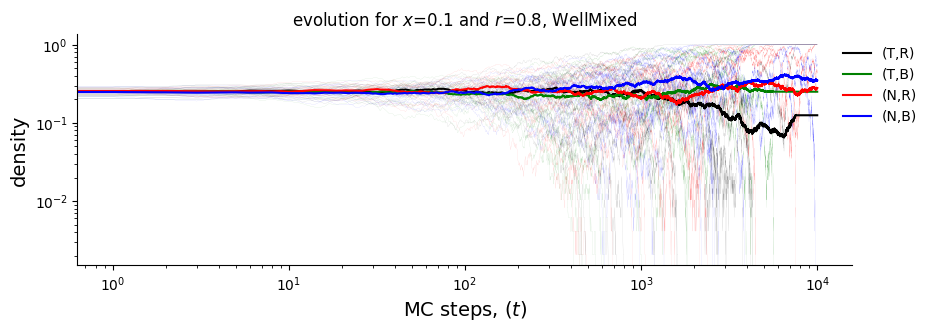

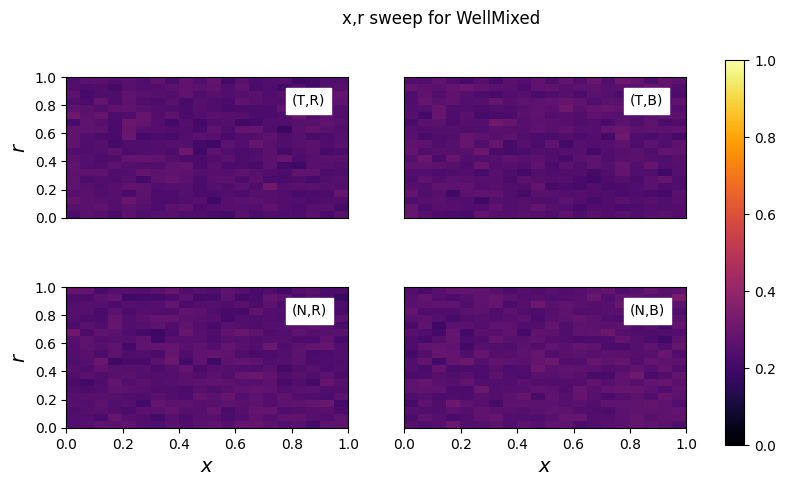

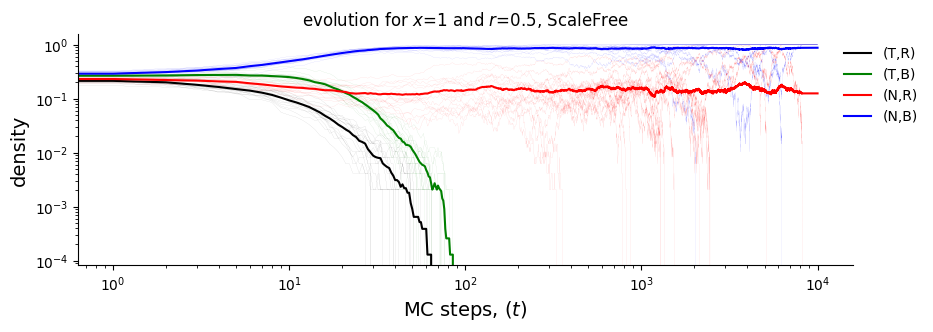

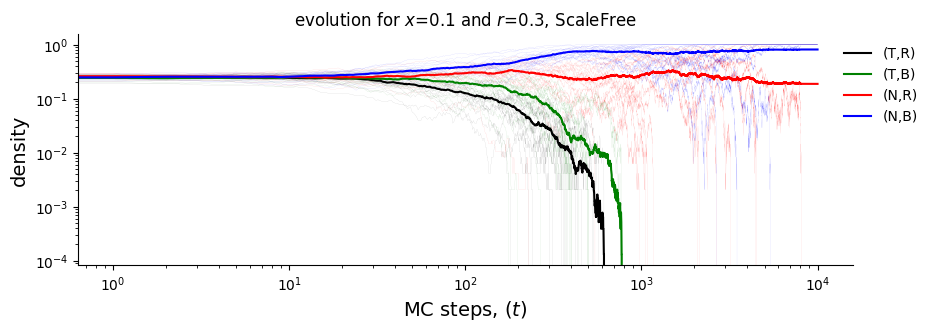

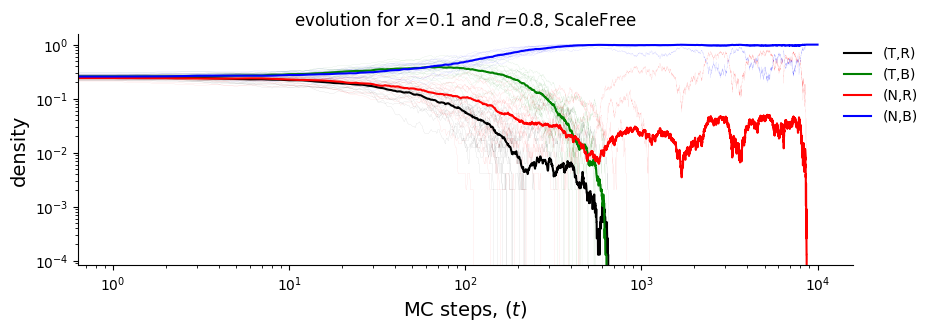

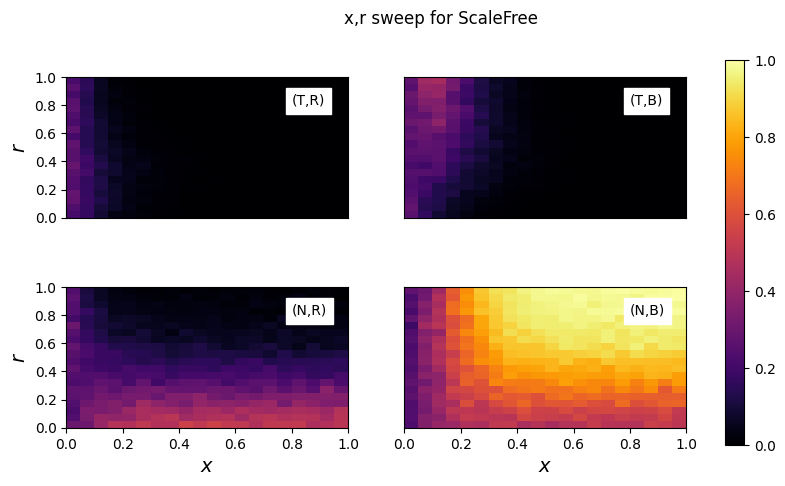

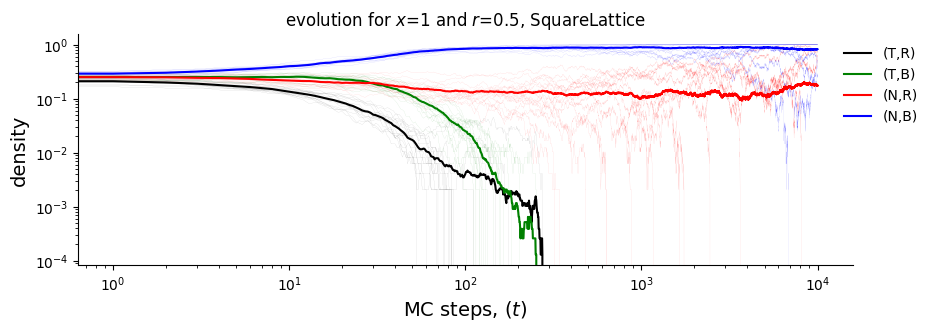

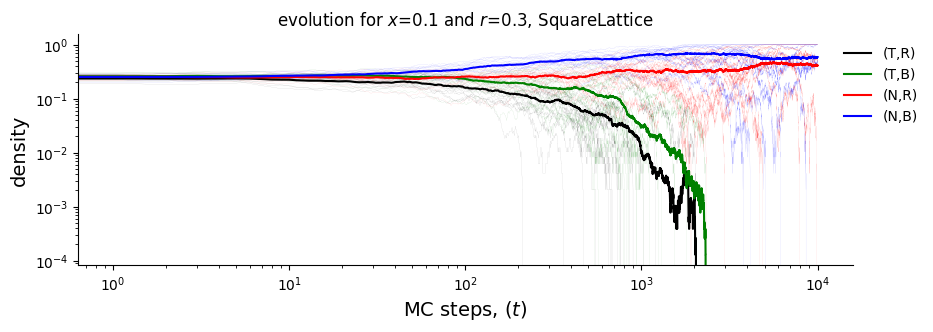

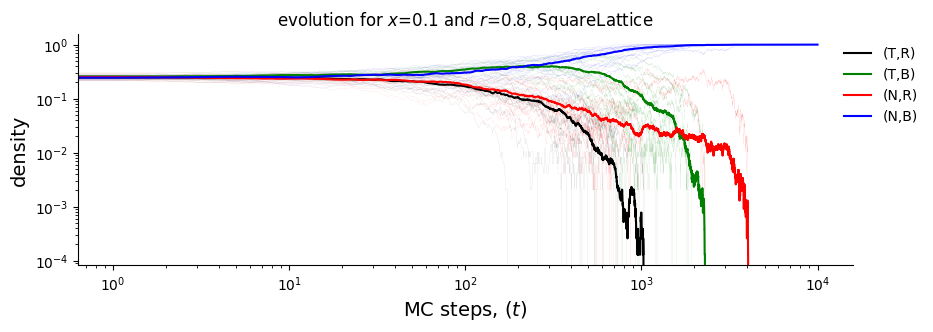

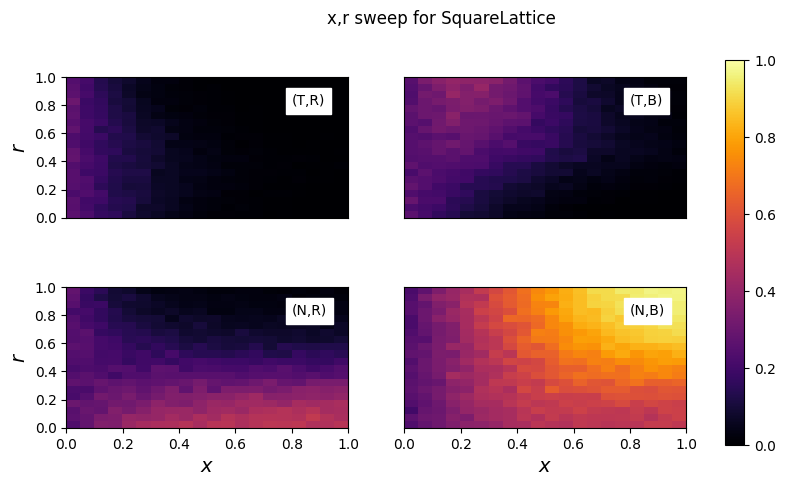

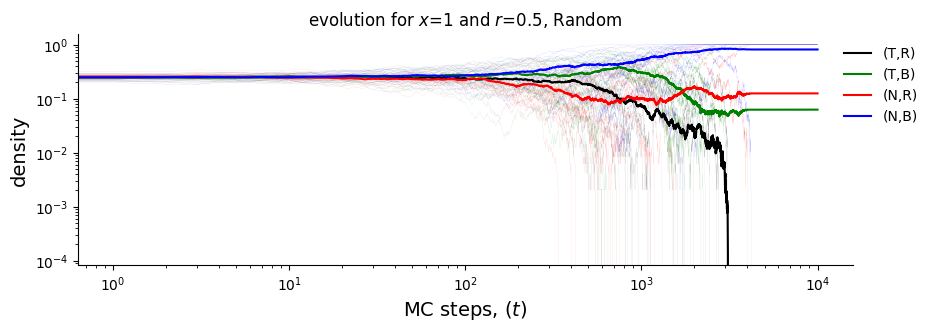

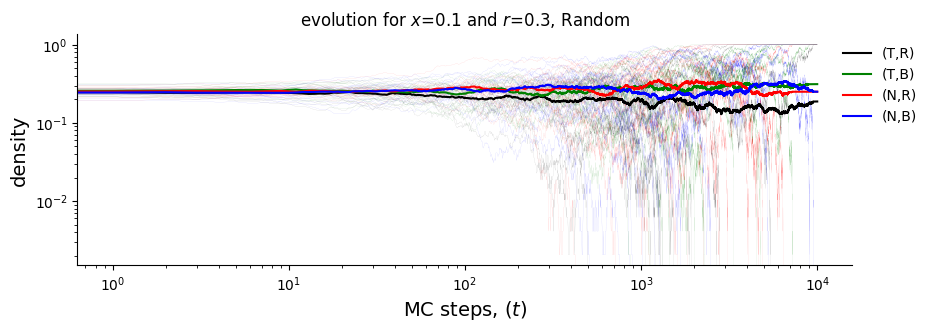

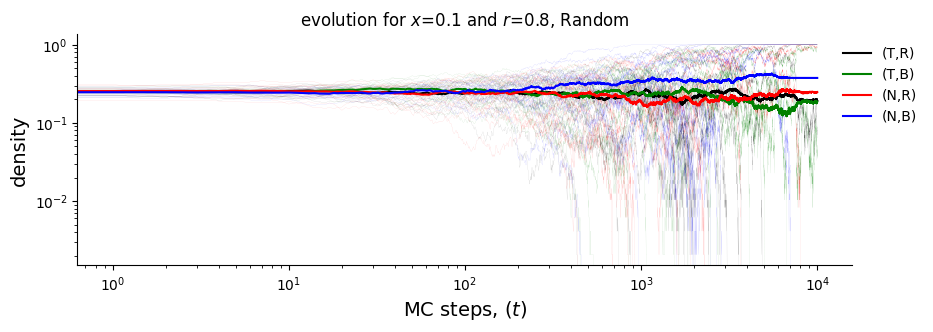

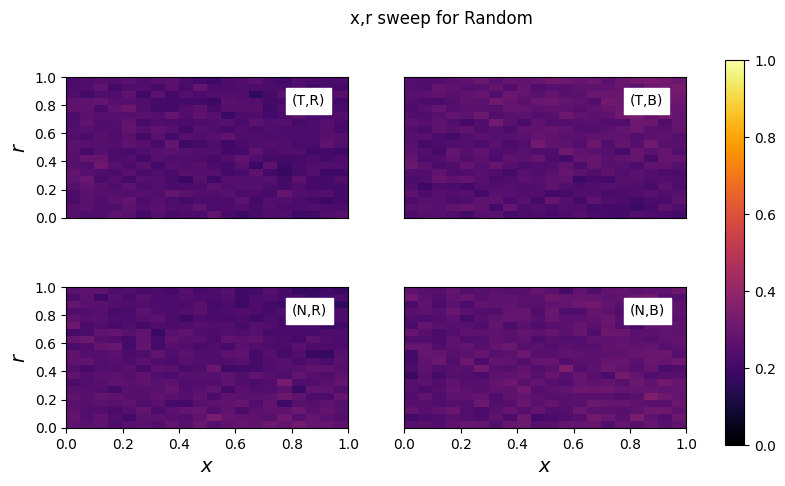

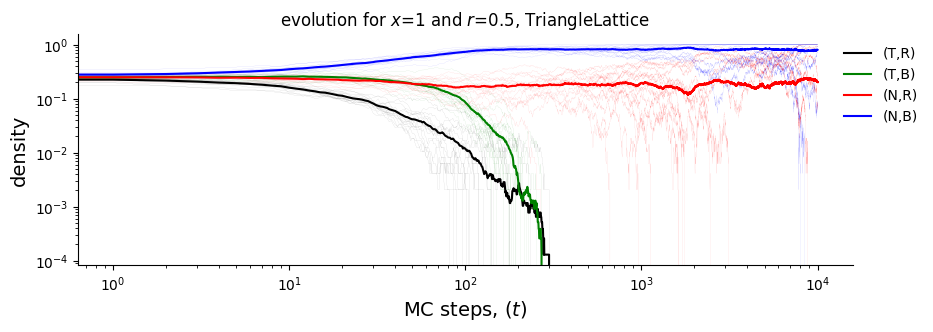

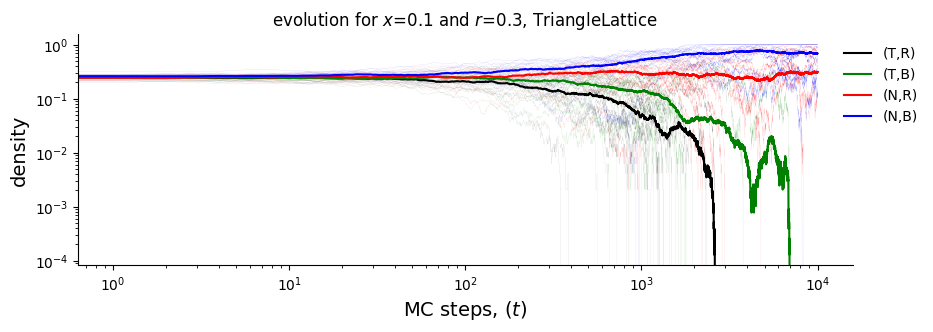

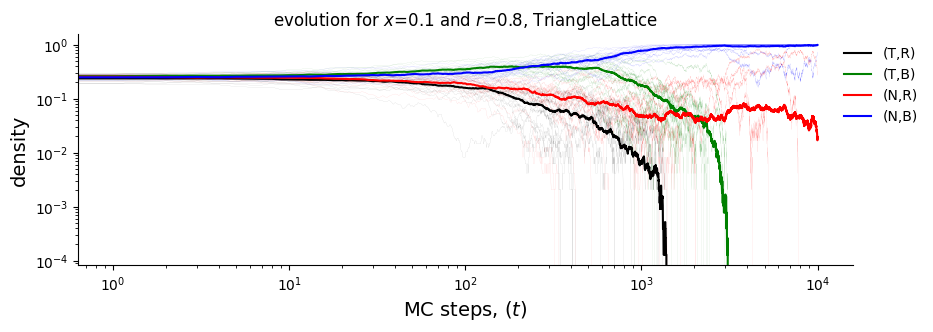

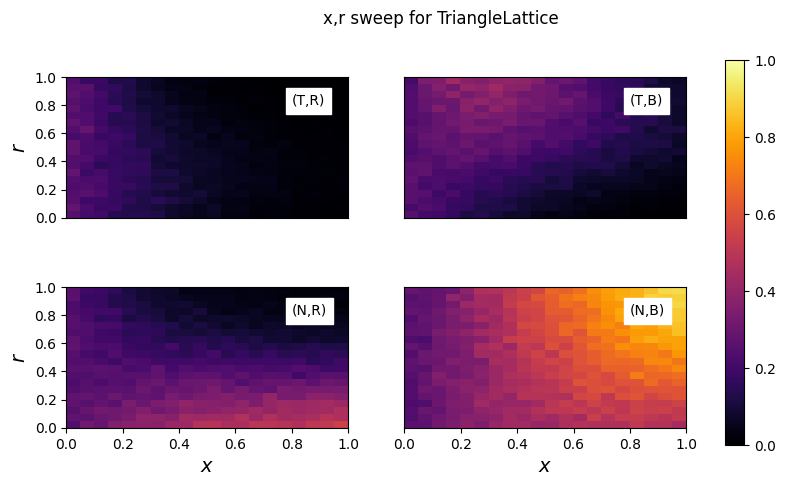

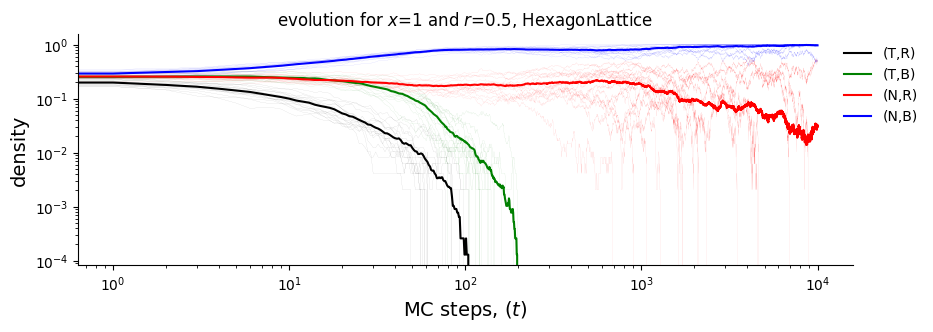

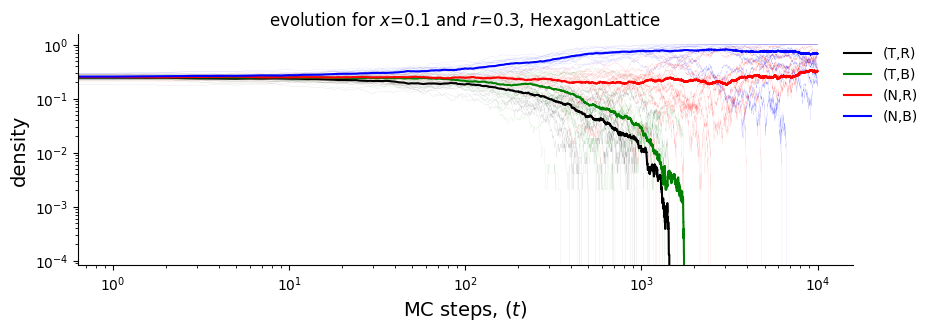

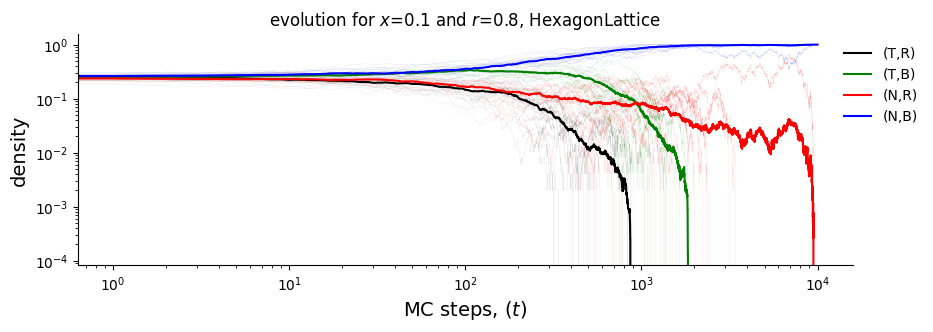

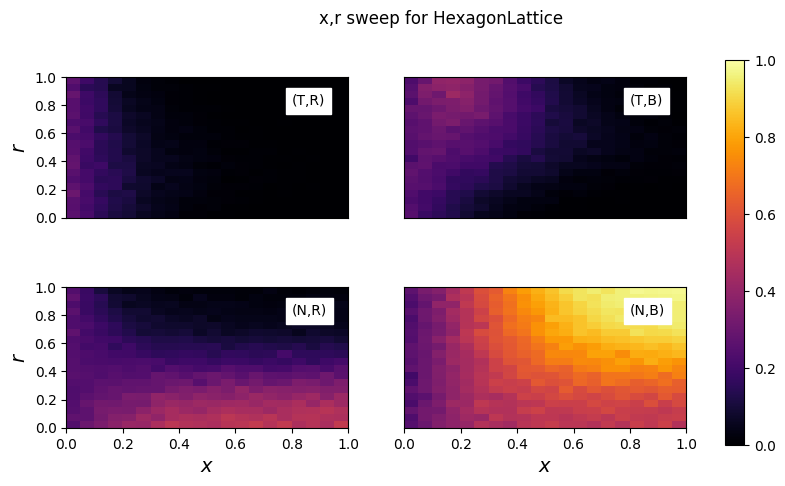

Evolution simulation took 330.51 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=1.00 r=0.50


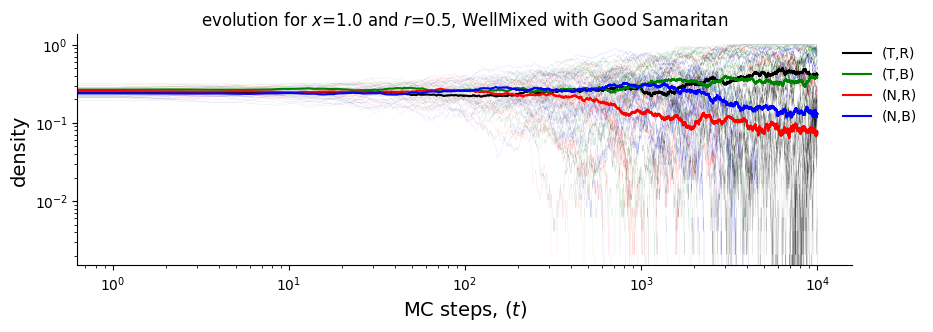

Evolution simulation took 330.04 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=1.00 r=0.50
Evolution simulation took 328.20 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=1.00 r=0.50
Evolution simulation took 330.81 s for nb_runs=16, nb_steps=10000 and n_threads=8, x=1.00 r=0.50


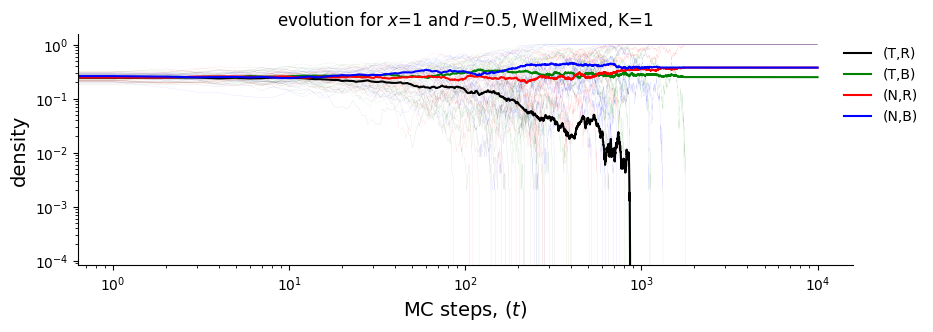

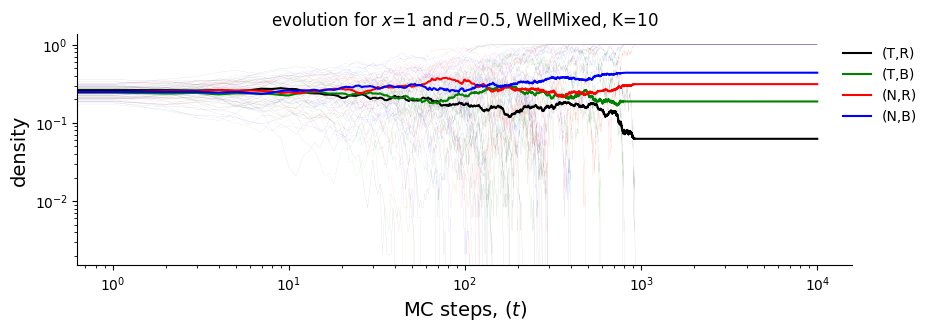

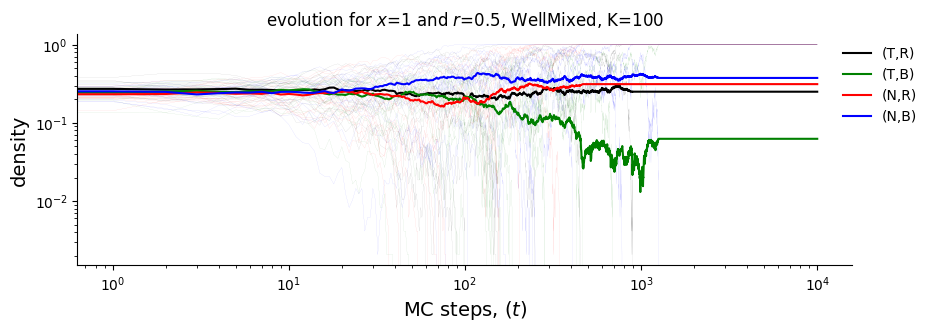

In [17]:
output1.show()
output2.show()
output3.show()